In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import seaborn as sns # data visualization
import matplotlib.pyplot as plt # data visualization
from nltk.corpus import stopwords # text preprocessing - stopwords
import re, string, unicodedata # text preprocessing - regular expressions, string
from bs4 import BeautifulSoup # html processing
from wordcloud import WordCloud, STOPWORDS # visualizing word cloud from corpus & ignoring stopwords
from collections import Counter # counter for most common words
from sklearn.feature_extraction.text import CountVectorizer # feature-oriented counting of words
from sklearn.model_selection import train_test_split # splitting the dataset into train & test sets
from keras.preprocessing import text, sequence # word tokenization
from keras.models import Sequential # class to construct the model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Flatten # RNN layers to be used
from keras.optimizers import Adam # optimizer to be used
from keras.callbacks import ReduceLROnPlateau # learning rate decay on plateau

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove840b300dtxt/glove.840B.300d.txt
/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [3]:
dataset = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
dataset.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


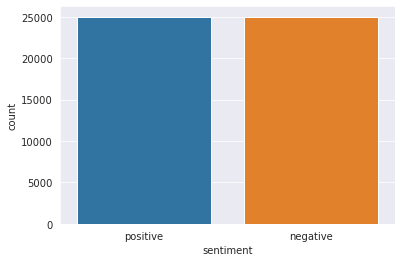

In [5]:
sns.set_style('darkgrid')
sns.countplot(dataset.sentiment)

# Text Preprocessing

In [6]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [7]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
dataset['review']=dataset['review'].apply(denoise_text)

# Word Clouds

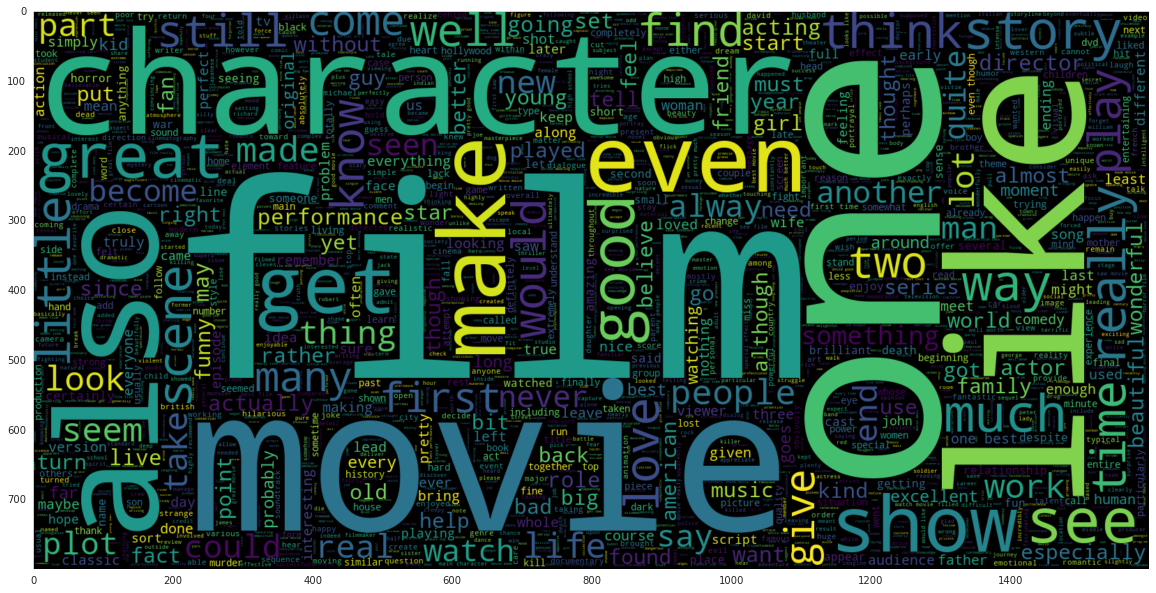

In [8]:
plt.figure(figsize=(20,20))
cloud = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop).generate(" ".join(dataset[dataset.sentiment == 'positive'].review))
plt.grid(b=None)
plt.imshow(cloud, interpolation='bilinear')

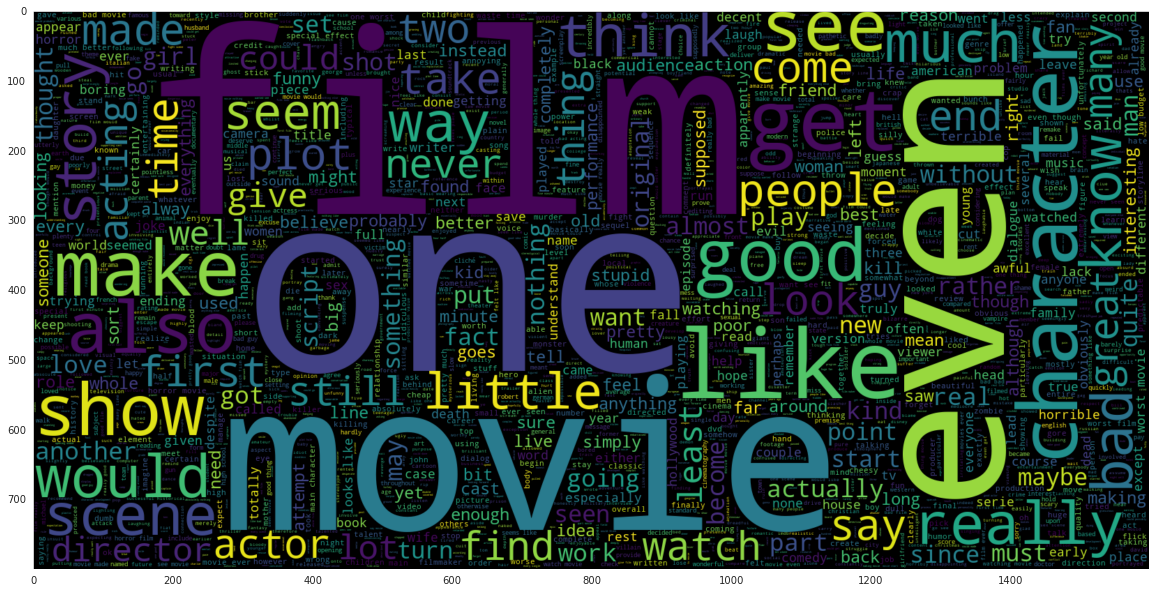

In [9]:
plt.figure(figsize=(20,20))
cloud = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop).generate(" ".join(dataset[dataset.sentiment == 'negative'].review))
plt.grid(b=None)
plt.imshow(cloud, interpolation='bilinear')

# Count Frequencies

**Character Count in Reviews**

Text(0.5, 0.98, 'Character Count in Reviews')

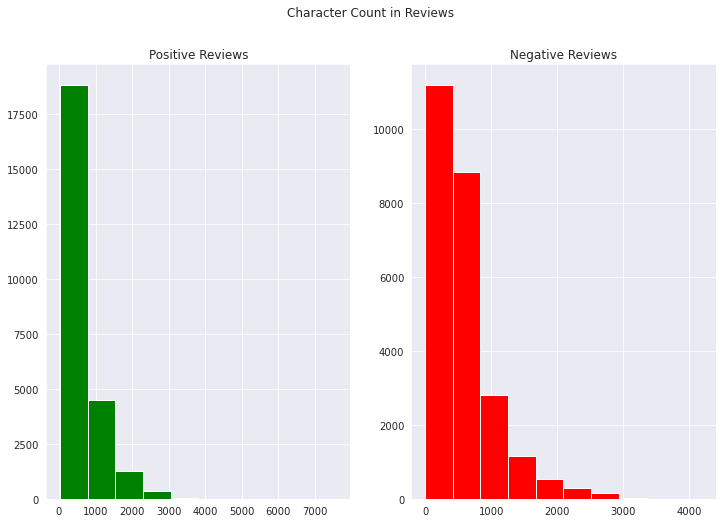

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))
text_len = dataset[dataset['sentiment'] == 'positive']['review'].str.len()
ax1.set_title('Positive Reviews')
ax1.hist(text_len, color='green')
text_len = dataset[dataset['sentiment'] == 'negative']['review'].str.len()
ax2.set_title('Negative Reviews')
ax2.hist(text_len, color='red')
fig.suptitle('Character Count in Reviews')

**Word Count in Reviews**

Text(0.5, 0.98, 'Word Count in Reviews')

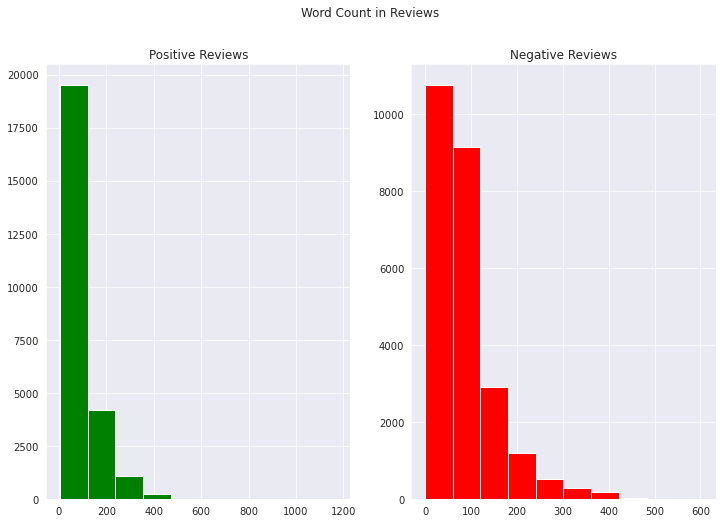

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))
text_len = dataset[dataset['sentiment'] == 'positive']['review'].str.split().map(lambda x: len(x))
ax1.set_title('Positive Reviews')
ax1.hist(text_len, color='green')
text_len = dataset[dataset['sentiment'] == 'negative']['review'].str.split().map(lambda x: len(x))
ax2.set_title('Negative Reviews')
ax2.hist(text_len, color='red')
fig.suptitle('Word Count in Reviews')

**Average Word Length in Reviews**

Test


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'Average Word Length in Reviews')

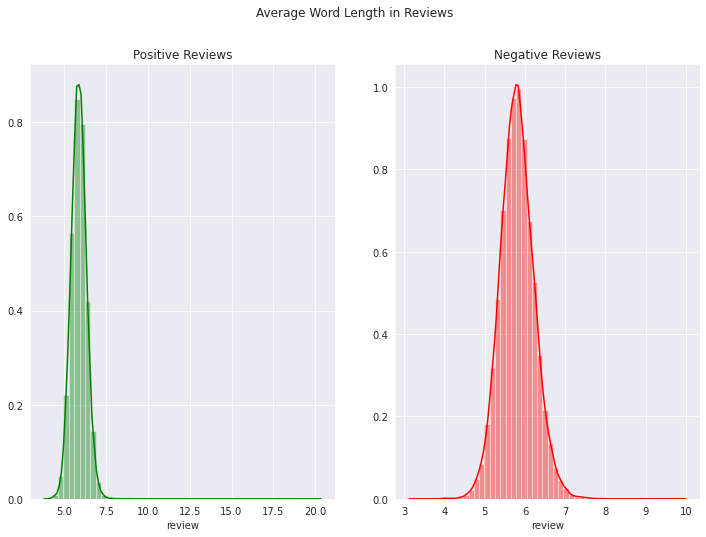

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))
text_len = dataset[dataset['sentiment'] == 'positive']['review'].str.split().apply(lambda x: [len(i) for i in x])
print("Test")
ax1.set_title('Positive Reviews')
sns.distplot(text_len.map(lambda x: np.mean(x)), ax=ax1, color='green')
text_len = dataset[dataset['sentiment'] == 'negative']['review'].str.split().apply(lambda x: [len(i) for i in x])
ax2.set_title('Negative Reviews')
sns.distplot(text_len.map(lambda x: np.mean(x)), ax=ax2, color='red')
fig.suptitle('Average Word Length in Reviews')

# N-Gram Analysis
An n-gram (unigram, bigram, trigram) is a way of analyzing what words and phrases are used in a text, which gives better insight about what was used most frequently, it turns out that the phrase "Over the top" is the most frequently used, maybe to describe something that is extremely good like a performance, a scenario, etc.

In [13]:
dataset['sentiment'] = pd.get_dummies(dataset['sentiment']).drop(['negative'], axis=1)

In [14]:
def get_corpus(texts):
    
    words = []
    
    for text in texts:
        for word in text.split():
            words.append(word.strip())
    
    return words

corpus = get_corpus(dataset.review)

corpus[:5]

['one', 'reviewers', 'mentioned', 'watching', 'oz']

In [15]:
print(len(corpus))

4484447


In [16]:
counter = Counter(corpus)
most_common = dict(counter.most_common(10))
most_common

{'movie': 61496,
 'film': 55088,
 'one': 45067,
 'like': 37303,
 'would': 23815,
 'even': 23720,
 'good': 23475,
 'really': 21806,
 'see': 20906,
 'get': 17692}

In [17]:
def get_top_ngrams(corpus, n, g):
    
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

**Unigram Analysis**

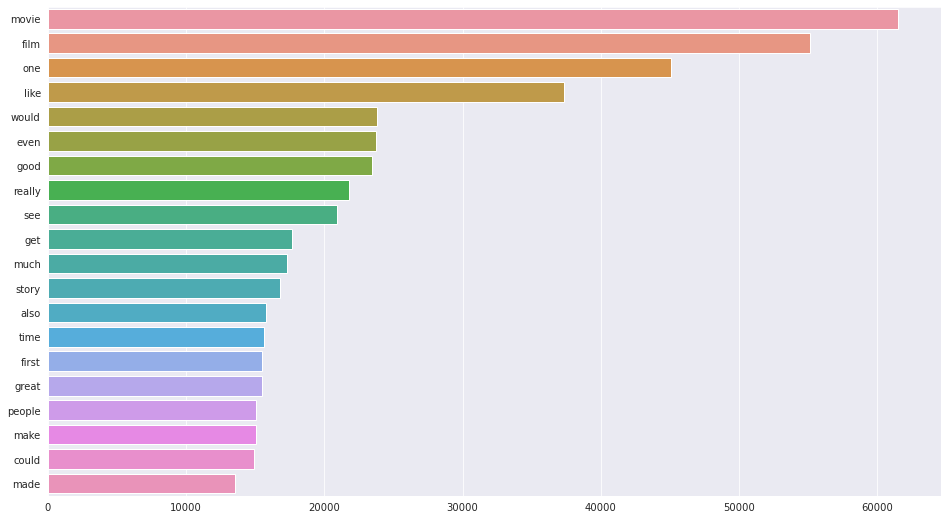

In [18]:
plt.figure(figsize=(16, 9))
most_common_uni = dict(get_top_ngrams(dataset.review, 20, 1))
sns.barplot(x=list(most_common_uni.values()), y=list(most_common_uni.keys()))

**Bigram Analysis**

In [ ]:
plt.figure(figsize=(16, 9))
most_common_bi = dict(get_top_ngrams(dataset.review, 20, 2))
sns.barplot(x=list(most_common_bi.values()), y=list(most_common_bi.keys()))

**Trigram Analysis**

In [ ]:
plt.figure(figsize=(16, 9))
most_common_uni = dict(get_top_ngrams(dataset.review, 20, 3))
sns.barplot(x=list(most_common_uni.values()), y=list(most_common_uni.keys()))

# Train-Test-Split
An important step in the Learning process as it enables us to test the model's performance on data it has never seen it before

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset.review, dataset.sentiment, train_size=0.9, random_state=0)
X_test_temp = X_test
y_test_temp = y_test

# Word Representations
There are many different ways to represent text for a model, because of course, models only understand numerical values. We're going to address 2 of them here: One-hot vectors and Word Embeddings

**One-hot-vectors**

![](https://static.bookstack.cn/projects/DeepLearning.ai-Summary/5-%20Sequence%20Models/Images/27.png)

One-hot encoding is a naive way to represent words, by simply sorting the most frequent words in a vector, and for the word occurrence in a sentence, it is replaced by the vector with it's value set to 1 and all other values are 0s

For example, if the first word here is 'Movies', it will be represented as [1, 0, 0, 0]

A big disadvantage of one-hot-encoding that it doesn't represent the difference and similarity between words, so it treats words such as 'Movie' and 'Film' as two completely different words, although the meaning is very close.

**Word Embeddings**

![](https://x-wei.github.io/images/Ng_DLMooc_c5wk2/pasted_image.png)

On the other hand, a word embedding is a pre-trained feature representation of a word learned from a larger corpus, which helps the model to distinguish more between words and treat words like 'Movie' and 'Film' as more similar words than 'Movie' and 'Character'

In this notebook we're going to use a pre-trained word embeddings

For this problem, we saw that the most frequent review length is about 100-120 words, and because the Network is fixed, we're going to use 128 as the max length of a training example, pad the shorter examples and truncate the longer ones.

In [ ]:
max_features = 10000
max_len = 128

**Word Tokenization**

In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

In [ ]:
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=max_len)

tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=max_len) 

**Creating the Embedding Matrix**

In [ ]:
EMBEDDING_FILE = "../input/glove840b300dtxt/glove.840B.300d.txt"

In [ ]:
def get_coeffs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
embeddings_dict = dict(get_coeffs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_dict.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
num_words = min(max_features, len(word_index))

embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embed_size))

for word, i in word_index.items():
    
    if i >= num_words: continue
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

**Setting up hyperparameters for training**

In [ ]:
batch_size = 256
epochs=10
embed_size=300

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

# Creating & Training the Model
For this particular problem we're going to use a Recurrent Neural Network (RNN), which is suitable for sequence data, with Bidirectional Long-Short-Term-Memory (LSTM) units.

In [ ]:
model = Sequential()

model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Bidirectional(LSTM(units=128)))
model.add(Dropout(rate=0.8))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.002), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[learning_rate_reduction])

# Analysis After Training

In [ ]:
print("Model Accuracy on Training Data: ", round(model.evaluate(X_train, y_train)[1]*100), "%")
print("Model Accuraccy on Testing Data: ", round(model.evaluate(X_test, y_test)[1]*100), "%")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Training & Testing Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['accuracy', 'val_accuracy'])
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Training & Testing Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax2.legend(['loss', 'val_loss'])
